In [1]:
# 2018-10-16
# A. Pendleton
# Intersect the Final gene set with the novel gaps that are in Zoey
#    that were called by Feichen

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
#Write PBS Script
def write_pbs_file(wkDir,cmdsFile,jobName, mem, jobCount):
    #write PBS file
    if '/scripts/' in wkDir:
        wkDir = wkDir.replace('/scripts/','')
    pbsFile = open(cmdsFile.replace('.cmds','.pbs'),'w')
    print('Writing pbs file: %s'% pbsFile)
    pbsFile.write('#!/bin/bash\n')
    pbsFile.write('#PBS -S /bin/bash\n')
    pbsFile.write('#PBS -V\n')
    pbsFile.write('#PBS -M ampend@med.umich.edu\n')
    pbsFile.write('#PBS -j oe\n')
    pbsFile.write('#PBS -N %s\n' % jobName)
    pbsFile.write('#PBS -o %s\n' % (wkDir + 'logs/'))
    pbsFile.write('#PBS -l pmem=%iG\n' % mem)
    pbsFile.write('#PBS -l nodes=1:ppn=1,qos=flux,walltime=100:00:00\n')
    pbsFile.write('##PBS -A medbsm_flux\n')
    pbsFile.write('##PBS -q flux\n')
    pbsFile.write('#PBS -A jmkidd_fluxod\n')
    pbsFile.write('#PBS -q fluxod\n')
    pbsFile.write('#PBS -t 1-%s\n' % jobCount)
    pbsFile.write('cd %s\n' % (wkDir))
    pbsFile.write('/home/ampend/links/kidd-lab/jmkidd-projects/scripts/perlUtils/run-by-id-log.pl %s %sBLAT_commands.logs $PBS_ARRAYID' % (cmdsFile,cmdsFile.replace('/scripts/','/logs/')))
    pbsFile.close()

# Define Inputs

### CREATE Input 1 = Zoey Exon BED file

##### Extract the exon coordinates from the transdecoder gff3 file which gives us exon positions for ALL genes. 
However, we only want the genes that made it into the final set (N=42,911 genes).


So, you'll need to read in the final gene ID list first, then extract exon positions only for the genes that made it into the final list.

In [3]:
finalDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/'

#Final list of 42,911 genes from Zoey annotations that went through annotations 
FinalGeneList = []
finalGeneIDFile = finalDir + 'FinalGenes_IDs.txt'

for line in open(finalGeneIDFile,'r'):
    line=line.rstrip()
    gene = line
    FinalGeneList.append(gene)

print('Added %i IDs from the final gene list' % len(FinalGeneList))

Added 42911 IDs from the final gene list


In [4]:
gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3'

#Use grep to only get the exons
cmd = 'grep "exon" %s > %s.exonsOnly' % (gffFile,gffFile) 
print(cmd)
runCMD(cmd)

grep "exon" /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3 > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3.exonsOnly


### Only need to generate the exon bed file once. 
## TAKES A LONG TIME
### So the below cell is hashed out and a second cell will read the bed file and save everything to the proper array

In [5]:
gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3'

exonBedfile = finalDir + 'Zoey_FinalGenes_exons.bed'

"""
exonBedFile = open(exonBedfile,'w')

parentGenes = []
lineCount = 0

for line in open(gffFile + '.exonsOnly','r'):
    line=line.rstrip().split('\t')
    if len(line) < 2:
        continue

    #only interested in exons
    if 'exon' not in line[2]:
        continue

    chrom,start,end = line[0],int(line[3])-1,int(line[4])
    geneID = line[8].split(';')[0].replace('ID=','')
    parentGene = line[8].split(';')[1].replace('Parent=','')
    
    #We only want the final genes. Some genes in this gff file did not make it through 
    #   post-processing filtration steps
    if parentGene not in FinalGeneList:
        continue
    lineCount+=1 

    parentGenes.append(parentGene) #keep track of the genes that we end up adding to see if we are missing any later
    exonBedFile.write('%s\t%i\t%i\t%s\n' % (chrom,start,end,geneID))
    
    if lineCount % 10000 == 0:
        print(lineCount)
    #if lineCount > 10000: # for testing
        #break
exonBedFile.close()

print('Done with %i exons' % lineCount )
unique_parentGenes = set(parentGenes)
print('From %i genes' % len(set(parentGenes)))"""

"\nexonBedFile = open(exonBedfile,'w')\n\nparentGenes = []\nlineCount = 0\n\nfor line in open(gffFile + '.exonsOnly','r'):\n    line=line.rstrip().split('\t')\n    if len(line) < 2:\n        continue\n\n    #only interested in exons\n    if 'exon' not in line[2]:\n        continue\n\n    chrom,start,end = line[0],int(line[3])-1,int(line[4])\n    geneID = line[8].split(';')[0].replace('ID=','')\n    parentGene = line[8].split(';')[1].replace('Parent=','')\n    \n    #We only want the final genes. Some genes in this gff file did not make it through \n    #   post-processing filtration steps\n    if parentGene not in FinalGeneList:\n        continue\n    lineCount+=1 \n\n    parentGenes.append(parentGene) #keep track of the genes that we end up adding to see if we are missing any later\n    exonBedFile.write('%s\t%i\t%i\t%s\n' % (chrom,start,end,geneID))\n    \n    if lineCount % 10000 == 0:\n        print(lineCount)\n    #if lineCount > 10000: # for testing\n        #break\nexonBedFile.c

In [6]:
parentGenes = []

for line in open(exonBedfile,'r'):
    line=line.rstrip().split('\t')
    chrom,start,end = line[0],int(line[1]),int(line[2])
    geneID = line[3]
    #parentID = geneID.rsplit('.',1)[0]
    parentID = geneID.split('.exon')[0]
    parentGenes.append(parentID)
    

print('%i exons added' % len(parentGenes))
unique_parentGenes = set(parentGenes)
print('From %i genes' % len(set(parentGenes)))

206013 exons added
From 42911 genes


In [7]:
#Check that we didn't miss any exon coordinates
missing = []

for gene in FinalGeneList:
    if gene not in unique_parentGenes:
        #print('ERROR: For some reason we are missing gene: ', gene)
        missing.append(gene)
print('Missing %i genes' % len(missing))

Missing 0 genes


### Input 2 = Feichen Gap BED file

In [9]:
gapBedfile = finalDir + 'Intersect_FeichenGaps/' + 'MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed'


In [ ]:
##########################################################################################
##########################################################################################
##########################################################################################

# Intersect the final exons with the novel gaps

In [10]:
intersectOutfile = finalDir + 'Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt'

cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (gapBedfile,exonBedfile,intersectOutfile)
print(cmd)
runCMD(cmd)

bedtools intersect -wo -a /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Intersect_FeichenGaps/MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed -b /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes_exons.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt


In [ ]:
##########################################################################################
##########################################################################################
##########################################################################################

# Read in the GC content pvalues

In [11]:
GCbed = '/nfs/turbo/jmkiddscr/feichens-projects/Zoey_pacbio/4_Post_analysis/QuicKmer/ROI_index_in_bianry.bed'

GCDict_pval = {}

for line in open(GCbed,'r'):
    line=line.rstrip().split('\t')
    ID = line[0] + ':' + line[1] + '-' + line[2]
    GCDict_pval[ID] = float(line[5])
    
print('added in GC pvalues for %i windows' % len(GCDict_pval.keys()))

added in GC pvalues for 13839 windows


### Get the pvalues for those windows that intersect with exons

In [12]:
added = []
couldntbeadded = []
pvalues = [] #for plotting the pvalues later
gapLiftPvalues, novelZoeyPvalues = [], [] 

for line in open(intersectOutfile,'r'):
    line=line.rstrip().split('\t')
    ID = line[0] + ':' + line[1] + '-' + line[2]
    
    #only add the gap once for histogram plotting later on
    if ID in added:
        continue
        
    added.append(ID)
    
    #Unfortunately, kmers could only be called in some of the windows, so not every
    #   one will have a pvalue associated with it
    if ID in GCDict_pval.keys():
        pvalue = GCDict_pval[ID]
        pvalues.append(pvalue)
        if '_GapLift' in line[3]:
            gapLiftPvalues.append(pvalue)
        if 'NovelZoey' in line[3]:
            novelZoeyPvalues.append(pvalue)

    else:
        couldntbeadded.append(ID)

print('In total %i gap windows have intersects with at least one exon\n' % len(added))
print('Got the pvalues for %i windows that intersected with exons:' % len(pvalues))
print('%i were the lifted over gaps' % len(gapLiftPvalues))
print('%i were with novel zoey gaps\n' % len(novelZoeyPvalues))
print('No pvalues were available for %i windows that intersected with exons' % len(couldntbeadded))


In total 3876 gap windows have intersects with at least one exon

Got the pvalues for 3422 windows that intersected with exons:
3422 were the lifted over gaps
0 were with novel zoey gaps

No pvalues were available for 454 windows that intersected with exons


### P-value histogram --- All intersects regardless of gap type

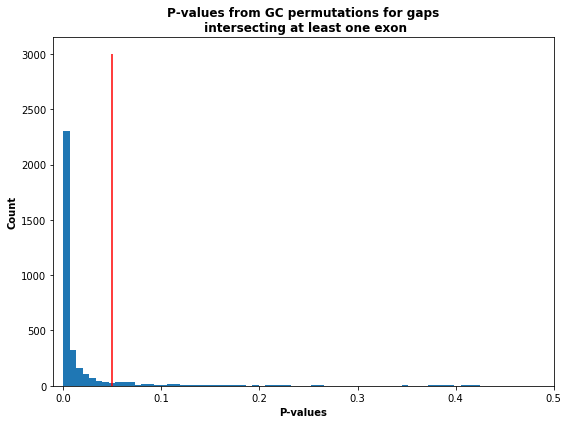

In [13]:
plt.figure(figsize=(8,6))

plt.hist(pvalues,bins=150)
plt.xlim(-0.01,0.5)
plt.vlines(ymin=0,ymax=3000,x=0.05,color='red')
#Add labels and title
plt.title('P-values from GC permutations for gaps\n intersecting at least one exon',fontweight='bold')
plt.xlabel('P-values',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.show()

### P-value histogram --- Only Gap Liftover type

Number of intersects significant = 3055  (0.892753 of windows)


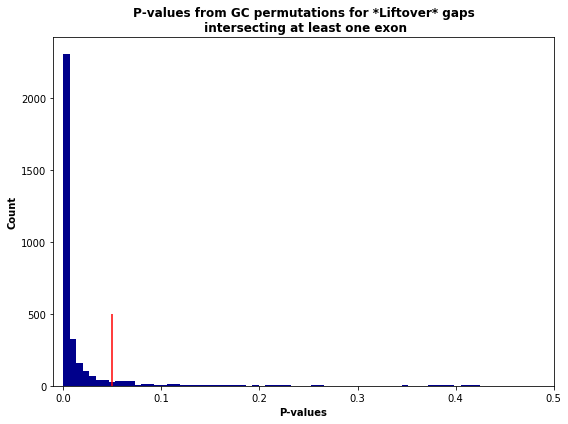

In [15]:
psig = 0
for p in pvalues:
    if p < 0.05:
        psig +=1
print('Number of intersects significant = %i  (%f of windows)' % (psig,psig/float(len(pvalues))))

plt.figure(figsize=(8,6))

plt.hist(pvalues,bins=150,color='darkblue')
plt.xlim(-0.01,0.5)
plt.vlines(ymin=0,ymax=500,x=0.05,color='red')
#Add labels and title
plt.title('P-values from GC permutations for *Liftover* gaps\n intersecting at least one exon',fontweight='bold')
plt.xlabel('P-values',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################


# Assessing exon number bias for those in novel regions
### We hypothesize that the novel exons are mostly in the beginning/ends of genes due to GC bias

#### Store the N'th exon number for every gene

In [17]:
exonCountDict = {}

for line in open(exonBedfile, 'r'):
    line=line.rstrip().split('\t')
    exonID = line[3]
    exonNum = int(exonID.split('.exon')[1]) #get the exon number for this bed entry
    geneID = exonID.split('.exon')[0] #gene identifier

    if geneID in exonCountDict.keys():
        if exonNum > exonCountDict[geneID]:
            exonCountDict[geneID] = exonNum
        else:
            continue
    else:
        exonCountDict[geneID] = exonNum
print('Added exon counts for the %i genes' % len(exonCountDict.keys()))

Added exon counts for the 42911 genes


# READING IN ALL GENE LENGTHS


In [18]:
def get_all_gene_lengths(bedfile):
    lengthDict = {}
    for line in open(bedfile,'r'):
        line=line.rstrip().split('\t')
        length = int(line[2])-int(line[1])
        geneID = line[3].split(';')[0]
        lengthDict[geneID] = length
    return lengthDict

#Get lengths of all genes
zoeyFullLengthGeneBed = finalDir + 'Zoey_FinalGenes.12.bed'
lengthDict = get_all_gene_lengths(zoeyFullLengthGeneBed)


# REAL DATA
## Intersecting non-shuffled novel gap insertions with final Zoey genes

In [77]:
########################################################################################################
def do_intersects(a,b,outfile):
    cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (a, b, outfile)
    runCMD(cmd)

########################################################################################
def parse_intersect(Dict,intersectFile): 

    geneLengths = [] #keeping track of gene lengths
    exonNums = []
    genes = []

    #Reading the intersect file results
    for line in open(intersectFile,'r'):
        line = line.rstrip().split('\t') #removing extraneous whitespace characters
        #Example exonID = Gene.23056::chr1.g10665.i1::g.23056::m.23056.exon9, exonNum = 9
        exonID = line[7]
        exonNum = int(exonID.split('.exon')[1])
        geneID = exonID.split('.exon')[0]
        
        #Gene length
        geneLength = lengthDict[geneID]
        if geneID not in genes:
            genes.append(geneID)
            #Only add gene length if the gene lenght hasn't already been added
            geneLengths.append(geneLength)
            
        #Store globally exonnums and genes
        exonNums.append(exonNum)
        
        exonMax = exonCountDict[geneID]
        if exonNum not in Dict.keys():
            Dict[exonNum] = []
            
        Dict[exonNum].append([exonNum,exonMax,exonID,geneLength])
            
    return Dict, genes, geneLengths, exonNums
########################################################################################
def parse_shuffle_intersect(Dict,intersectFile): 

    geneLengths = [] #keeping track of gene lengths
    exonNums = []
    genes = []

    #Reading the intersect file results
    for line in open(intersectFile,'r'):
        line = line.rstrip().split('\t') #removing extraneous whitespace characters
        #Example exonID = Gene.23056::chr1.g10665.i1::g.23056::m.23056.exon9, exonNum = 9
        exonID = line[3]
        exonNum = int(exonID.split('.exon')[1])
        geneID = exonID.split('.exon')[0]
        
        #Gene length
        geneLength = lengthDict[geneID]
        if geneID not in genes:
            genes.append(geneID)
            #Only add gene length if the gene lenght hasn't already been added
            geneLengths.append(geneLength)
            
        #Store globally exonnums and genes
        exonNums.append(exonNum)
        
        exonMax = exonCountDict[geneID]
        if exonNum not in Dict.keys():
            Dict[exonNum] = []
            
        Dict[exonNum].append([exonNum,exonMax,exonID,geneLength])
            
    return Dict, genes, geneLengths, exonNums
##########################################################################
def get_max_exon_Counts(exonBedfile):
    exonCountDict = {}

    for line in open(exonBedfile, 'r'):
        line=line.rstrip().split('\t')
        exonID = line[3]
        exonNum = int(exonID.split('.exon')[1]) #get the exon number for this bed entry
        geneID = exonID.split('.exon')[0] #gene identifier

        if geneID in exonCountDict.keys():
            if exonNum > exonCountDict[geneID]:
                exonCountDict[geneID] = exonNum
            else:
                continue
        else:
            exonCountDict[geneID] = exonNum
    print('Added exon counts for the %i genes' % len(exonCountDict.keys()))
    return exonCountDict
##########################################################################
def get_all_gene_lengths(bedfile):
    lengthDict = {}
    for line in open(bedfile,'r'):
        line=line.rstrip().split('\t')
        length = int(line[2])-int(line[1])
        geneID = line[3].split(';')[0]
        lengthDict[geneID] = length
    return lengthDict

##########################################################################
#Keepint track of how long each exon is per position in gene
def make_empty_permLengthDict():
    positions = ['E1','E2','E3','N2','N1','N']
    permLengthDict = {}
    for p in positions:
        permLengthDict[p] = []

    return permLengthDict

##########################################################################
def parse_intersect_file(outfile,permLengthDict):
    #####LOOP
    E1,E2,E3,MIDDLE,N2,N1,N = 0,0,0,0,0,0,0
    totalIntersects, totalPassingIntersects = 0, 0

    for line in open(outfile,'r'):
        line=line.rstrip().split('\t')
        #all intersects
        totalIntersects += 1

        #details on this gene
        exonNum, geneID = int(line[7].split('.exon')[1]), line[7].split('.exon')[0]
        maxExon =  int(exonCountDict[geneID])
        exonLength = int(line[6]) - int(line[5])
        distanceFromEndExon = maxExon - exonNum

        #If not at least 3 exons, skip
        if maxExon <= 3:
            continue
            
        totalPassingIntersects += 1 #How many pass after exon count filtration
            
        if exonNum == 1: # FIRST EXON
            E1 += 1
            permLengthDict['E1'].append(exonLength)
            continue
        if exonNum == 2: # SECOND EXON
            E2 += 1
            permLengthDict['E2'].append(exonLength)
            continue
        if exonNum == 3: # THIRD EXON
            E3 += 1
            permLengthDict['E3'].append(exonLength)
            continue
        if distanceFromEndExon == 2:  # THIRD TO LAST EXON
            N2 += 1
            permLengthDict['N2'].append(exonLength)
            continue
        if distanceFromEndExon == 1:  # SECOND TO LAST EXON
            N1 += 1
            permLengthDict['N1'].append(exonLength)
            continue
        if distanceFromEndExon == 0:  # LAST EXON
            N += 1
            permLengthDict['N'].append(exonLength)
            continue
        else:
            MIDDLE+=1
            continue


    return E1,E2,E3,MIDDLE,N2,N1,N,totalIntersects,totalPassingIntersects,permLengthDict
##########################################################################
def get_gene_lengths_from_intersect_file(outfile):
    geneLengths, passingGeneLengths, singleExonCounts = [], [], 0
    genes = [] #Dont want to add gene lengths multiple times, only add once
    
    for line in open(outfile,'r'):
        line=line.rstrip().split('\t')

        #details on this gene
        exonNum, geneID = int(line[7].split('.exon')[1]), line[7].split('.exon')[0]
        geneLength = int(lengthDict[geneID])
        maxExon =  int(exonCountDict[geneID])

        #total intersect gene lengths
        if geneID not in genes:
            geneLengths.append(geneLength)
            if maxExon <= 3:
                passingGeneLengths.append(geneLength)
                
        genes.append(geneID)

        #How many are singletons
        if maxExon == 1:
            singleExonCounts += 1

        if maxExon <= 3:
            continue

    

    return geneLengths, passingGeneLengths, singleExonCounts

#### Store the N'th exon number for every gene

In [85]:
####### INPUTS ############
#Get lengths of all genes
zoeyFullLengthGeneBed = finalDir + 'Zoey_FinalGenes.12.bed'
lengthDict = get_all_gene_lengths(zoeyFullLengthGeneBed)
#Get max exon counts possible for all genes
zoeyExonBed = finalDir + 'Zoey_FinalGenes_exons.bed'
exonCountDict = get_max_exon_Counts(zoeyExonBed)

intersectFile = finalDir + 'Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt'
outfile = intersectFile


#GLOBAL FOR 1000 PERMS - number of exons in each possible position
real_exon1,real_exon2,real_exon3,real_n2,real_n1,real_n = [],[],[],[],[],[]
real_prop_exon1,real_prop_exon2,real_prop_exon3,real_prop_n2,real_prop_n1,real_prop_n = [],[],[],[],[],[]

realLengthDict = make_empty_permLengthDict() #keep track of the lengths of the exons based on positions (E1-->N)


# PARSE INTERSECT FILE
E1,E2,E3,MIDDLE,N2,N1,N,totalIntersects,passing,realLengthDict = parse_intersect_file(outfile, realLengthDict)
print(E1,E2,E3,MIDDLE,N2,N1,N)

real_total_intersectCount = count_lines(intersectFile)
real_total_fractionExonIntersecting = totalIntersects/float(possibleExons)
real_passing_fractionExonIntersecting = passing/float(possibleExons)

# ADD TO GLOBAL TALLY OF COUNTS AND FRACTION OF COUNTS
#counts
real_exon1, real_exon2, real_exon3, real_n2, real_n1, real_n = E1, E2, E3, N2, N1, N
#proportion of passing intersects
real_prop_exon1,real_prop_exon2, real_prop_exon3, real_prop_n2, real_prop_n1, real_prop_n = E1/float(passing), E2/float(passing), E3/float(passing), N2/float(passing), N1/float(passing), N/float(passing)


geneLengths, passingGeneLengths, singleExonCounts = get_gene_lengths_from_intersect_file(outfile)
real_geneLength = np.mean(geneLengths)
real_passing_geneLength = np.mean(passingGeneLengths)
real_singleExon = singleExonCounts/float(totalIntersects)

print('Proportion of exons that are Exon #1 position',real_prop_exon1)    
print('Proportion of exons that are Nth position',real_prop_n)
print('\nReal proportion of intersecting exons \n\tthat are single exon genes: ', real_singleExon)

Added exon counts for the 42911 genes
2056 249 130 474 81 102 272
Proportion of exons that are Exon #1 position 0.6111771700356718
Proportion of exons that are Nth position 0.08085612366230678

Real proportion of intersecting exons 
	that are single exon genes:  0.25337331334332835


In [28]:
print(E1,E2,E3,N2,N1,N)

2056 249 130 81 102 272


/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


365.706712062 307.112449799 308.5 192.802469136 386.941176471 2368.81985294


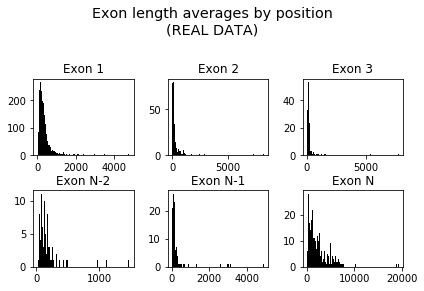

In [33]:
f, axarr = plt.subplots(2, 3)
st = f.suptitle('Exon length averages by position\n(REAL DATA)', fontsize="x-large")

#Exon 1 Lengths
axarr[0, 0].hist(realLengthDict['E1'],bins=100,color='black')
axarr[0, 0].set_title('Exon 1')
#Exon 2 Lengths
axarr[0, 1].hist(realLengthDict['E2'],bins=100,color='black')
axarr[0, 1].set_title('Exon 2')
#Exon 3 Lengths
axarr[0, 2].hist(realLengthDict['E3'],bins=100,color='black')
axarr[0, 2].set_title('Exon 3')
#Exon N-2 Lengths
axarr[1, 0].hist(realLengthDict['N2'],bins=100,color='black')
axarr[1, 0].set_title('Exon N-2')
#Exon N-1 Lengths
axarr[1, 1].hist(realLengthDict['N1'],bins=100,color='black')
axarr[1, 1].set_title('Exon N-1')
#Exon N Lengths
axarr[1, 2].hist(realLengthDict['N'],bins=100,color='black')
axarr[1, 2].set_title('Exon N')
plt.tight_layout()

st.set_y(1.0)
f.subplots_adjust(top=0.75)

plt.show()

real_mean_E1_length, real_mean_E2_length, real_mean_E3_length, real_mean_N2_length, real_mean_N1_length, real_mean_N_length = np.mean(realLengthDict['E1']), np.mean(realLengthDict['E2']), np.mean(realLengthDict['E3']), np.mean(realLengthDict['N2']), np.mean(realLengthDict['N1']), np.mean(realLengthDict['N']) 
print(real_mean_E1_length, real_mean_E2_length, real_mean_E3_length, real_mean_N2_length, real_mean_N1_length, real_mean_N_length) 


### Plot REAL exon number bias
### COUNTS

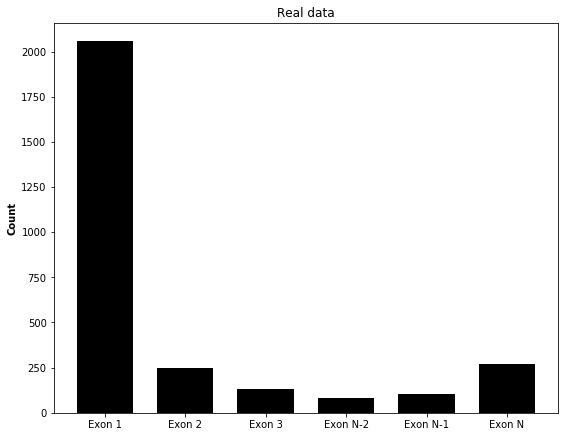

In [36]:
xs = ['Exon 1','Exon 2','Exon 3','Exon N-2','Exon N-1','Exon N']
ys = [real_exon1, real_exon2, real_exon3, real_n2, real_n1, real_n]
pos = [0,1,2,3,4,5]

plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,int(ys[p]),width = 0.7,align='center',color='black',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
#_ = plt.title('Exon Count for gene models intersecting novel ROI',fontweight='bold')
_ = plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.title('Real data')
plt.savefig(finalDir + 'Intersect_FeichenGaps/' + 'RealData_exonposition.pdf')
plt.show()

### Plot REAL exon number bias
### Proportion of intersects passing exon count filtrations

In [39]:
ys, xs

([0.6111771700356718,
  0.07401902497027349,
  0.03864447086801427,
  0.024078478002378122,
  0.03032104637336504,
  0.08085612366230678],
 ['Exon 1', 'Exon 2', 'Exon 3', 'Exon N-2', 'Exon N-1', 'Exon N'])

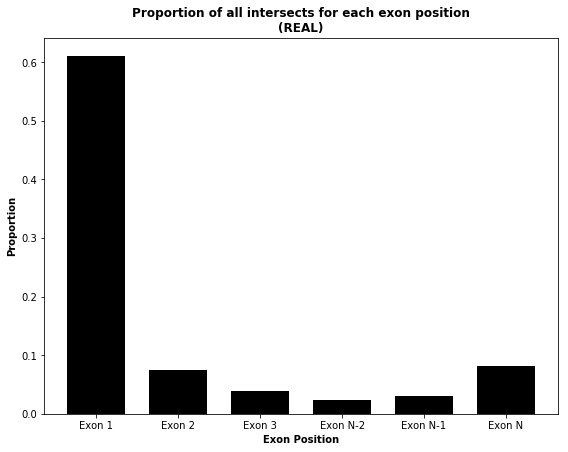

In [43]:
xs = ['Exon 1','Exon 2','Exon 3','Exon N-2','Exon N-1','Exon N']
ys = [real_prop_exon1, real_prop_exon2, real_prop_exon3, real_prop_n2, real_prop_n1, real_prop_n]
pos = [0,1,2,3,4,5]

plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,float(ys[p]),width = 0.7,align='center',color='black',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
#_ = plt.title('Exon Count for gene models intersecting novel ROI',fontweight='bold')
_ = plt.ylabel('Proportion',fontweight='bold')
_ = plt.xlabel('Exon Position',fontweight='bold')
plt.tight_layout()
plt.title('Proportion of all intersects for each exon position\n(REAL)',fontweight='bold')
plt.savefig(finalDir + 'Intersect_FeichenGaps/' + 'RealData_PROPORTION_exonposition.pdf')
plt.show()

In [ ]:
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################

# *
# Permutations
# *

In [44]:
#Write all xpclr sweeps to a output bedfile to be shuffled below
finalGeneDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/'
gapDir = finalGeneDir + 'Intersect_FeichenGaps/'

#make directory for the permutations
permDir = gapDir + 'permutations/'
cmd = 'mkdir -p %s' % permDir
runCMD(cmd)

#Gap file
novel_gapBedFile = gapDir + 'MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed'

#Inputs
ZoeyGapBedFile = '~/links/kidd-lab/genomes/zoey/assemblies/2.3/gaps/zoey.2.3.gaps.bed'
ZoeyGenome = gapDir + 'Zoey2.3_AutosomesOnly.genome'
ZoeyGeneBedFile = finalGeneDir + 'Zoey_FinalGenes_exons_chr1-38_chrX.bed' #Only genes on chr1-38,chrX (no CTG or scaffold genes)


In [84]:
####### INPUTS ############
#Get lengths of all genes
zoeyFullLengthGeneBed = finalDir + 'Zoey_FinalGenes.12.bed'
lengthDict = get_all_gene_lengths(zoeyFullLengthGeneBed)
#Get max exon counts possible for all genes
zoeyExonBed = finalDir + 'Zoey_FinalGenes_exons.bed'
exonCountDict = get_max_exon_Counts(zoeyExonBed)
possibleExons = count_lines(ZoeyGeneBedFile)

#GLOBAL FOR 1000 PERMS - number of exons in each possible position
perm_exon1,perm_exon2,perm_exon3,perm_n2,perm_n1,perm_n = [],[],[],[],[],[]
perm_prop_exon1,perm_prop_exon2,perm_prop_exon3,perm_prop_n2,perm_prop_n1,perm_prop_n = [],[],[],[],[],[]

#How many intersect out of possible exons, and how many that pass length criteria intersect
perm_total_intersectCounts = []
perm_total_fractionExonIntersecting,perm_passing_fractionExonIntersecting = [], []

#Keep track of exon position lengths
perm_singleExon = [] # what prop of perms are single exon genes
perm_mean_E1_length, perm_mean_E2_length, perm_mean_E3_length, perm_mean_N2_length, perm_mean_N1_length, perm_mean_N_length = [], [], [], [], [], []
perm_geneLengths, perm_passing_geneLengths = [], [] #average gene lengths

for i in range(0,1000): #1000 permutations
    permLengthDict = make_empty_permLengthDict() #keep track of the lengths of the exons based on positions (E1-->N)
    
    # SHUFFLE THE GAP INSERTION POSITIONS
    shuffledFile = permDir + 'shuffle_%i.bed' % i
    cmd = 'bedtools shuffle -excl %s -i %s -g %s > %s' % (ZoeyGapBedFile, novel_gapBedFile, ZoeyGenome, shuffledFile)
    #runCMD(cmd)
    
    
    # INTERSECT THE SHUFFLES WITH ZOEY EXONS
    outfile = permDir + 'intersect_zoeygenes_withgaps_%i.txt' % (i)
    #do_intersects(shuffledFile,ZoeyGeneBedFile,outfile)
    perm_total_intersectCounts.append(count_lines(outfile))
    
    # PARSE INTERSECT FILE
    E1,E2,E3,MIDDLE,N2,N1,N,totalIntersects,passing,permLengthDict = parse_intersect_file(outfile,permLengthDict)
    #print(E1,E2,E3,MIDDLE,N2,N1,N,passing)

    perm_total_fractionExonIntersecting.append(totalIntersects/float(possibleExons))
    perm_passing_fractionExonIntersecting.append(passing/float(possibleExons))
    
    # ADD TO GLOBAL TALLY OF COUNTS AND FRACTION OF COUNTS
    #counts
    perm_exon1.append(E1), perm_exon2.append(E2), perm_exon3.append(E3), perm_n2.append(N2), perm_n1.append(N1), perm_n.append(N)
    #proportion of passing intersects
    perm_prop_exon1.append(E1/float(passing)), perm_prop_exon2.append(E2/float(passing)), perm_prop_exon3.append(E3/float(passing)), perm_prop_n2.append(N2/float(passing)), perm_prop_n1.append(N1/float(passing)), perm_prop_n.append(N/float(passing))

    
    # KEEP TRACK OF GENE/EXON LENGTHS
    geneLengths, passingGeneLengths, singleExonCounts = get_gene_lengths_from_intersect_file(outfile)
    perm_singleExon.append(singleExonCounts/float(totalIntersects))
    perm_geneLengths.append(np.mean(geneLengths)) # regardless of exon number minimum
    perm_passing_geneLengths.append(np.mean(passingGeneLengths)) # >3 exons
    
    #Add to lists for the average exon position lengths per permutation
    perm_mean_E1_length.append(np.mean(permLengthDict['E1']))
    perm_mean_E2_length.append(np.mean(permLengthDict['E2']))
    perm_mean_E3_length.append(np.mean(permLengthDict['E3']))
    perm_mean_N2_length.append(np.mean(permLengthDict['N2']))
    perm_mean_N1_length.append(np.mean(permLengthDict['N1']))
    perm_mean_N_length.append(np.mean(permLengthDict['N']))
    
    if i % 50 == 0:
        print(i)
    
print('Real single exon: ', real_singleExon)
print('Permuted average single exon: ', perm_singleExon)


Added exon counts for the 42911 genes
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Real single exon:  0.25337331334332835
Permuted average single exon:  [0.20396776193428395, 0.19183168316831684, 0.22110552763819097, 0.22208955223880597, 0.1895933014354067, 0.1981076286221171, 0.1976456009913259, 0.20320855614973263, 0.20454545454545456, 0.19914215686274508, 0.19273399014778325, 0.21837708830548927, 0.20472895040369088, 0.20215956808638272, 0.20597584233947872, 0.18328358208955223, 0.1994933502216593, 0.1959739490822972, 0.20048163756773027, 0.2107594936708861, 0.2, 0.19797525309336333, 0.23076923076923078, 0.19515151515151516, 0.20326223337515684, 0.21532846715328466, 0.20581257413997628, 0.20860341779611077, 0.20526630760023937, 0.20050761421319796, 0.18593272171253822, 0.21465295629820053, 0.20533010296789825, 0.19298245614035087, 0.1983323406789756, 0.21700879765395895, 0.19829683698296838, 0.21675191815856779, 0.19650391802290537, 0.2047146401985111

### Plotting the average length (N=1000) of exons in each position for genes with >3 exons that intersect with the novel gap insertions

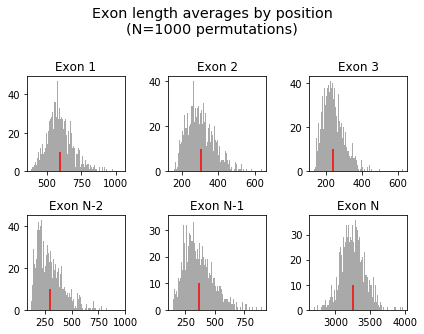

In [46]:
f, axarr = plt.subplots(2, 3)
st = f.suptitle('Exon length averages by position\n(N=1000 permutations)', fontsize="x-large")

#Exon 1 Lengths
axarr[0, 0].hist(perm_mean_E1_length,bins=100,color='darkgrey')
axarr[0, 0].set_title('Exon 1')
axarr[0, 0].vlines(np.mean(perm_mean_E1_length),0,10,color='red')
#Exon 2 Lengths
axarr[0, 1].hist(perm_mean_E2_length,bins=100,color='darkgrey')
axarr[0, 1].set_title('Exon 2')
axarr[0, 1].vlines(np.mean(perm_mean_E2_length),0,10,color='red')
#Exon 3 Lengths
axarr[0, 2].hist(perm_mean_E3_length,bins=100,color='darkgrey')
axarr[0, 2].set_title('Exon 3')
axarr[0, 2].vlines(np.mean(perm_mean_E3_length),0,10,color='red')
#Exon N-2 Lengths
axarr[1, 0].hist(perm_mean_N2_length,bins=100,color='darkgrey')
axarr[1, 0].set_title('Exon N-2')
axarr[1, 0].vlines(np.mean(perm_mean_N2_length),0,10,color='red')
#Exon N-1 Lengths
axarr[1, 1].hist(perm_mean_N1_length,bins=100,color='darkgrey')
axarr[1, 1].set_title('Exon N-1')
axarr[1, 1].vlines(np.mean(perm_mean_N1_length),0,10,color='red')
#Exon N Lengths
axarr[1, 2].hist(perm_mean_N_length,bins=100,color='darkgrey')
axarr[1, 2].set_title('Exon N')
axarr[1, 2].vlines(np.mean(perm_mean_N_length),0,10,color='red')

st.set_y(1.15)
f.subplots_adjust(top=0.75)

plt.tight_layout()
plt.show()
    

# Bias toward exon positions in permutations 

exon 1, exon 2, exon 3, n-2, n-1, n
105.022 87.207 85.325 66.212 76.465 258.351


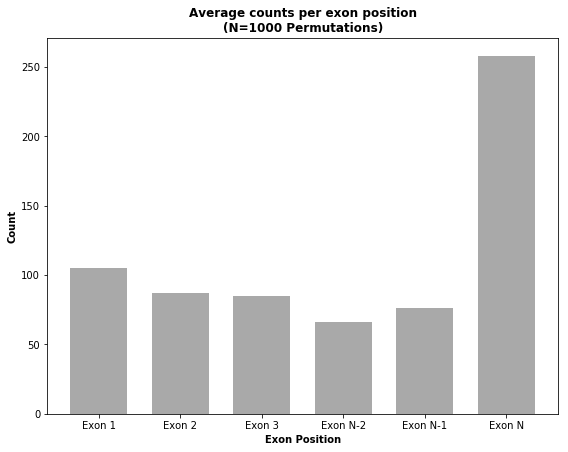

In [47]:
mean_perm_e1 = int(np.mean(perm_exon1))
mean_perm_e2 = int(np.mean(perm_exon2))
mean_perm_e3 = int(np.mean(perm_exon3)) 
mean_perm_n2 = int(np.mean(perm_n2))
mean_perm_n1 = int(np.mean(perm_n1))
mean_perm_n = int(np.mean(perm_n))

print('exon 1, exon 2, exon 3, n-2, n-1, n')
print(np.mean(perm_exon1),np.mean(perm_exon2),np.mean(perm_exon3),np.mean(perm_n2),np.mean(perm_n1),np.mean(perm_n))

xs = ['Exon 1','Exon 2','Exon 3','Exon N-2','Exon N-1','Exon N']
#ys = [int(np.mean(perm_exon1)),int(np.mean(perm_exon2)),int(np.mean(perm_exon3)),int(np.mean(perm_n2)),int(np.mean(perm_n1)),int(np.mean(n))]
ys = [mean_perm_e1, mean_perm_e2, mean_perm_e3, mean_perm_n2, mean_perm_n1, mean_perm_n]
pos = [0,1,2,3,4,5]
#labels = xs

#fig, ax = plt.subplots()
plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,int(ys[p]),width = 0.7,align='center',color='darkgrey',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
#_ = plt.title('Exon Count for gene models intersecting novel ROI',fontweight='bold')
_ = plt.xlabel('Exon Position',fontweight='bold')
_ = plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.title('Average counts per exon position\n(N=1000 Permutations)',fontweight='bold')
#plt.savefig(permDir + 'plots/Permutations_exonposition.pdf')
plt.show()

## Plotted as proportion

exon 1, exon 2, exon 3, n-2, n-1, n
0.0873502348354 0.0725281762726 0.0709633265063 0.0550591357845 0.0635857561281 0.214938205927


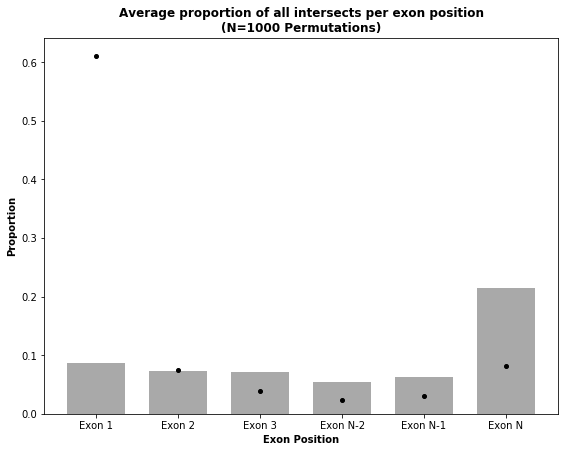

In [58]:
mean_perm_prop_e1 = float(np.mean(perm_prop_exon1))
mean_perm_prop_e2 = float(np.mean(perm_prop_exon2))
mean_perm_prop_e3 = float(np.mean(perm_prop_exon3)) 
mean_perm_prop_n2 = float(np.mean(perm_prop_n2))
mean_perm_prop_n1 = float(np.mean(perm_prop_n1))
mean_perm_prop_n = float(np.mean(perm_prop_n))

print('exon 1, exon 2, exon 3, n-2, n-1, n')
print(np.mean(perm_prop_exon1),np.mean(perm_prop_exon2),np.mean(perm_prop_exon3),np.mean(perm_prop_n2),np.mean(perm_prop_n1),np.mean(perm_prop_n))

xs = ['Exon 1','Exon 2','Exon 3','Exon N-2','Exon N-1','Exon N']
#ys = [int(np.mean(perm_exon1)),int(np.mean(perm_exon2)),int(np.mean(perm_exon3)),int(np.mean(perm_n2)),int(np.mean(perm_n1)),int(np.mean(n))]
ys = [mean_perm_prop_e1, mean_perm_prop_e2, mean_perm_prop_e3, mean_perm_prop_n2, mean_perm_prop_n1, mean_perm_prop_n]
pos = [0,1,2,3,4,5]
#labels = xs

#fig, ax = plt.subplots()
plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,float(ys[p]),width = 0.7,align='center',color='darkgrey',label=l)
    names.append(xs[p])
    ticks.append(p)

#Add REAL points for context
plt.plot(0, real_prop_exon1, marker='o', markersize=4, color="black")
plt.plot(1, real_prop_exon2, marker='o', markersize=4, color="black")
plt.plot(2, real_prop_exon3, marker='o', markersize=4, color="black")
plt.plot(3, real_prop_n2, marker='o', markersize=4, color="black")
plt.plot(4, real_prop_n1, marker='o', markersize=4, color="black")
plt.plot(5, real_prop_n, marker='o', markersize=4, color="black")


_ =plt.xticks(ticks,names,fontsize=10)
#_ = plt.title('Exon Count for gene models intersecting novel ROI',fontweight='bold')
_ = plt.xlabel('Exon Position',fontweight='bold')
_ = plt.ylabel('Proportion',fontweight='bold')
plt.tight_layout()
plt.title('Average proportion of all intersects per exon position\n(N=1000 Permutations)',fontweight='bold')
#plt.savefig(permDir + 'plots/Permutations_exonposition.pdf')
plt.show()

## Histogram of the proportion of exons intersecting a gap regardless of max exon count

P-value =  0.0


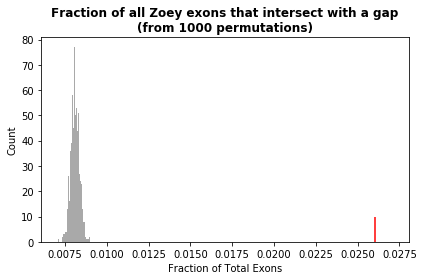

In [91]:
higher = 0
for r in perm_total_fractionExonIntersecting:
    if r >= real_total_fractionExonIntersecting:
        higher+=1
print('P-value = ', higher/1000)

plt.hist(perm_total_fractionExonIntersecting,bins=50,color='darkgrey')
plt.xlim(real_total_fractionExonIntersecting - 0.02,real_total_fractionExonIntersecting+0.002)
plt.vlines(real_total_fractionExonIntersecting,0,10,color='red')
plt.title('Fraction of all Zoey exons that intersect with a gap\n(from 1000 permutations)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Fraction of Total Exons')
plt.tight_layout()
plt.show()


### Fraction of intersecting exons that ARE AT LEAST 4 EXONS LONG

P-value =  0.0


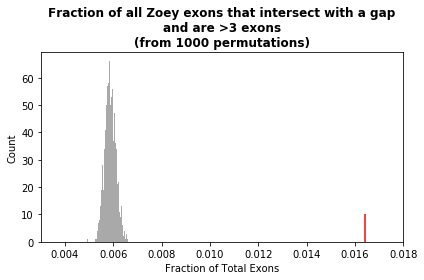

In [90]:
higher = 0
for r in perm_passing_fractionExonIntersecting:
    if r >= real_passing_fractionExonIntersecting:
        higher+=1
print('P-value = ', higher/1000)

plt.hist(perm_passing_fractionExonIntersecting,bins=50,color='darkgrey')
plt.xlim(0.003,0.018)
plt.vlines(real_passing_fractionExonIntersecting,0,10,color='red')
plt.title('Fraction of all Zoey exons that intersect with a gap\nand are >3 exons\n(from 1000 permutations)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Fraction of Total Exons')
plt.tight_layout()
plt.show()


## Histogram of the length of genes intersecting gap (genes can only be counted once even if they intersect with multiple gaps)

P-value =  0.0


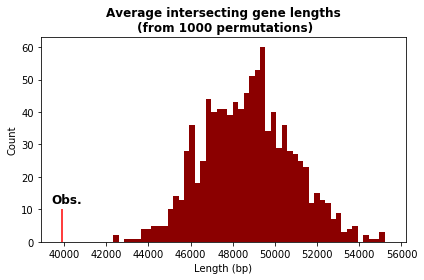

In [81]:
lower = 0
for r in perm_geneLengths:
    if r <= real_geneLength:
        lower+=1
print('P-value = ', lower/1000)

plt.hist(perm_geneLengths,bins=50,color='darkred')
plt.xlim(real_geneLength - 1000,max(perm_geneLengths)+1000)
plt.vlines(real_geneLength,0,10,color='red')
plt.title('Average intersecting gene lengths\n (from 1000 permutations)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Length (bp)')
plt.text(real_geneLength-500, 12, 'Obs.', fontsize=12,fontweight='bold')
plt.tight_layout()
plt.show()


## Total number of intersects (can count doubles)

P-value =  0.0


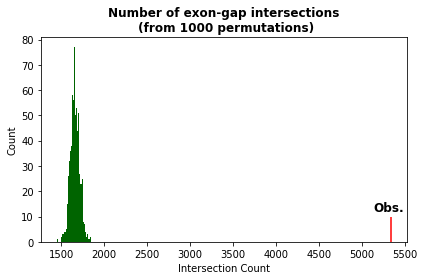

In [88]:
higher = 0
for r in perm_total_intersectCounts:
    if r >= real_total_intersectCount:
        higher+=1
print('P-value = ', higher/1000)


plt.hist(perm_total_intersectCounts,bins=50,color='darkgreen')
#plt.xlim(real_fractionIntersecting - 0.02,max(perm_total_fractionExonIntersecting)+0.02)
plt.vlines(real_total_intersectCount,0,10,color='red')
plt.title('Number of exon-gap intersections\n (from 1000 permutations)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Intersection Count')
plt.text(real_total_intersectCount-200, 12, 'Obs.', fontsize=12,fontweight='bold')
plt.tight_layout()
plt.show()


## Total number of single exon intersects 

P-value =  0.0


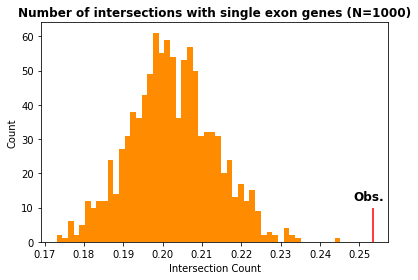

In [83]:
higher = 0
for r in perm_singleExon:
    if r >= real_singleExon:
        higher+=1
print('P-value = ', higher/1000)

plt.hist(perm_singleExon,bins=50,color='darkorange')
#plt.xlim(real_fractionIntersecting - 0.02,max(perm_total_fractionExonIntersecting)+0.02)
plt.vlines(real_singleExon,0,10,color='red')
plt.title('Number of intersections with single exon genes (N=1000)',fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Intersection Count')
plt.text(real_singleExon-0.005, 12, 'Obs.', fontsize=12,fontweight='bold')
plt.tight_layout()
plt.show()


# What about when only one exon from a gene can intersect with a gap

In [ ]:
Dict = {}

for line in open(intersectOutfile,'r'):
    line = line.rstrip().split('\t')
    
    #Determine what the max number of exons for this gene is
    geneID = line[7].split('.exon')[0]
    exonMax = exonCountDict[geneID]
    
    if geneID not in Dict.keys():
        Dict[geneID] = {}
        Dict[geneID]['exonMax'] = exonMax
        Dict[geneID]['intersectingnovelregions'] = []
        
    Dict[geneID]['intersectingnovelregions'].append(line[7])
    
#######################################################################################

intersectingExonNumberDict2 = {}
dontQualify = 0

for geneID in Dict.keys():
    if len(Dict[geneID]['intersectingnovelregions']) > 1:
        continue
    exonMax = int(Dict[geneID]['exonMax'])
    
    #Skip single exon genes
    if exonMax < 3:
        dontQualify+=1
        continue
    
    exonID = Dict[geneID]['intersectingnovelregions']
    #Get which exon intersected with the novel region from the bedfile
    for e in exonID:
        exonNumIntersecting = int(e.split('.exon')[1])
    
    #Now store positional information for each exon
    #If the exon is the first exon, simple, store it in key == 1
    if exonNumIntersecting <= 3:
        if exonNumIntersecting not in intersectingExonNumberDict2.keys():
            intersectingExonNumberDict2[exonNumIntersecting] = []
        intersectingExonNumberDict2[exonNumIntersecting].append([exonID,exonMax])
        continue
    
    else:
        #Distance from the end
        distanceFromLastExon = exonMax - exonNumIntersecting
        if distanceFromLastExon == 0:
            exonNumIntersecting = 'N'
        if distanceFromLastExon == 1:
            exonNumIntersecting = 'N-1'  
        if distanceFromLastExon == 2:
            exonNumIntersecting = 'N-2'
        if distanceFromLastExon > 2:
            exonNumIntersecting = 'Middle Exon'
        if exonNumIntersecting not in intersectingExonNumberDict2.keys():
            intersectingExonNumberDict2[exonNumIntersecting] = []
        intersectingExonNumberDict2[exonNumIntersecting].append([exonID,exonMax])
print('%i gene models that intersect with novel regions dont qualify (less than three exons)' % dontQualify)        
  
    
countArray2 = []
for count in intersectingExonNumberDict2.keys():
    if 'Middle' not in str(count):
        countArray2.append(['Exon ' + str(count),len(intersectingExonNumberDict2[count])])
    else:
        
        countArray2.append([str(count),len(intersectingExonNumberDict2[count])])
        
print(countArray2)
        
#######################################################################################

#labels, ys = zip(*countArray)
#xs = np.arange(len(labels)) 

xs = ['Exon 1','Exon 2','Exon 3','Middle Exon','Exon N-2','Exon N-1','Exon N']
ys = [1931,85,64,97,13,25,139]
pos = [0,1,2,3,4,5,6]
#labels = xs

#fig, ax = plt.subplots()
plt.figure(figsize=(8, 6))  # width:20, height:3

names, ticks = [], []
for p in range(0,len(pos)):
    l = xs[p]
    _ = plt.bar(p,int(ys[p]),width = 0.7,align='center',color='darkblue',label=l)
    names.append(xs[p])
    ticks.append(p)

_ =plt.xticks(ticks,names,fontsize=10)
_ = plt.title('Exon Count for gene models intersecting novel ROI\nOnly one novel exon',fontweight='bold')
_ = plt.ylabel('Count')
plt.tight_layout()
plt.show()